# Nexar Challenge 2
Re-Train it with nexar Dataset
<img src="nb_images/logo-nexar.png" width="50%">

In [30]:
import pandas as pd
from pandas import ExcelWriter
from scipy import misc
import argparse
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io
import scipy.misc
import os, sys
import shutil
import fnmatch
import math
import random, shutil
from PIL import Image
import PIL
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from nexar_yolo_utils2 import predict_any, create_model, get_batch, iou, mAP_eval, nexar_eval_test

from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from retrain_yolo import process_data,process_data_pil,get_classes,get_anchors,get_detector_mask,train,draw

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" # importing iPython output fucntioanlity 

#sys.path.append(os.getcwd()+'/yad2k/models' )
#sys.path.append(os.getcwd()+'/yad2k/utils' )

from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body, yolo_eval
# from yad2k.utils.draw_boxes import draw_boxes

%matplotlib inline


In [31]:
# Definitons and paths

# path to images and boxes
images_dir = os.getcwd()+'/../data/Training/nexet_2017_'
boxes_dir = os.getcwd()+'/../data/Training/train_boxes.csv'

training_chunks_path = os.getcwd()+'/../data/Training/training_chunks/'
training_data_chunks_size = 8*30 # Number of samples of  chuncked downs training data files. Need to be multiple of smallest mini-batch to be used
training_chunks_name = 'training_chunk_'
images_test_dir = os.getcwd()+'/../data/Test/nexet_2017_test'
test_results_output = os.getcwd()+'/../data/Test/test_boxes.xlsx'
test_results_output_csv = os.getcwd()+'/../data/Test/test_boxes.csv'

# anchors_path to anchors file, defaults to yolo_anchors.txt
anchors_path = "model_data/yolo_anchors.txt"

image_shape = (720., 1280.)

# Default anchor boxes
YOLO_ANCHORS = np.array(
    ((0.57273, 0.677385), (1.87446, 2.06253), (3.33843, 5.47434),
     (7.88282, 3.52778), (9.77052, 9.16828)))

# path to classes file, defaults to pascal_classes.txt
# Nexar classes ->
class_idx= {"car":0,"bus":1,"pickup_truck":2,"truck":3,"van":4}
classes_path = "model_data/nexar_classes.txt"

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 1 - Preparing the data


To perform training we need:
* class_names,     anchors,      image_data,      boxes,     detectors_mask,      matching_true_boxes

Put the training data into a format: Data['class_names'], etc

We will load the original data, process it and save it into several npz (Data-chuncks) to perform mini-batches training.

Normal batches sizes are 8 and 32 samples, so we will make sure our data npz (Data-chuncks) are multiple of 8: 160 samples per chunk
  

In [32]:
# Get anchors and classes names
class_names = get_classes(classes_path)
anchors = get_anchors(anchors_path)

In [33]:
dts_images_names = []
for dts in range(1,4):
    print("Processing Dataset folder", dts)
    dts_files = os.listdir(images_dir+str(dts)) # files in dataset dts
    for i,image_sample in enumerate(dts_files): #for all images in the dataset folder
        dts_files[i] = images_dir+str(dts)+"/"+image_sample
    random.shuffle(dts_files) # Shuffle the order of data-chunks: Try to avoid biases
    dts_images_names.extend(dts_files)
print(' Training folders explored')

test_files = os.listdir(images_test_dir) # files in dataset dts
for i,image_sample in enumerate(test_files): # for all images in the dataset folder
    test_files[i] = images_test_dir+"/"+image_sample
random.shuffle(test_files) # Shuffle the order 
print(' Test folder explored')


Processing Dataset folder 1
Processing Dataset folder 2
Processing Dataset folder 3
 Training folders explored
 Test folder explored


# 1 B - Data Generator check

Get the datast location and create a callback that generates model inputs on demand

In [34]:
validation_split = 0.05
random.shuffle(dts_images_names) # Shuffle the order of data-chunks: Try to avoid biases
training_set_files = dts_images_names[0:math.ceil(len(dts_images_names)*(1-validation_split))]
val_set_files = dts_images_names[math.floor(len(dts_images_names)*(1-validation_split)):]

In [6]:
# Sanity check
for i in get_batch(dts_images_names, 32, boxes_dir,class_idx,classes_path,anchors_path):
#     print(i)
    pass

KeyboardInterrupt: 

# 2 A - Training with Data Chunks

Train with the data processed and saved

We will iterate over all the chunked data to create true epochs and will use mini-batch training

We will use 2 different training steeps to steer the nerwork to our purpose,

In [2]:
chunks_files_names = fnmatch.filter(os.listdir( training_chunks_path  ), training_chunks_name+"*")
# Load just the first chunk 
data = np.load(training_chunks_path+'/'+chunks_files_names[2])
print("     I found ",data['image_data'].shape[0]," data samples on the data chunk")

NameError: name 'fnmatch' is not defined

[[0.46055556 0.76679842 0.53666667 0.46640316 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


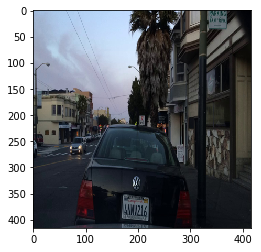

In [8]:
idx_test = 50
print( data['boxes'][idx_test] )
plt.imshow(data['image_data'][idx_test])
plt.show()

In [10]:
# Clear logs
shutil.rmtree(os.getcwd()+'/.logs')

##  Training 1st pass: Transfer learning

In [10]:
### 1st pass: Transfer learning
number_true_epochs = 2
# Create the model
model_body, model = create_model(data['anchors'], data['class_names'], load_pretrained=True, freeze_body=True)

# Configure the training
model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.

logging =  TensorBoard(log_dir='.logs', histogram_freq=1, batch_size=32, write_graph=True,
                                       write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# run: $ tensorboard --logdir=.logs
validation_split = 0.05 # Do we really wanna do validation on each chunk?


In [11]:
### 1st pass: Transfer learning
for true_epoch in range(1,number_true_epochs+1):
    random.shuffle(chunks_files_names) # Shuffle the order of data-chunks: Try to avoid biases
    for chunk_file in chunks_files_names:
        print('      True epoch: '+str(true_epoch)+'/'+str(number_true_epochs))
        # Load the data
        data = np.load(training_chunks_path+'/'+chunk_file)
#         print("      Loading "+chunk_file+' with ',data['image_data'].shape[0]," data samples")
        
        # train the model
        model.fit([data['image_data'], data['boxes'], data['detectors_mask'], data['matching_true_boxes']],
                  np.zeros(len(data['image_data'])),
                  validation_split=validation_split,
                  batch_size=32,
                  epochs=1,
                  callbacks=[logging])
    
model.save_weights('trained_stage_1.h5')

      True epoch: 1/2
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 31s 10ms/step - loss: 406.6783 - acc: 0.0000e+00 - val_loss: 199.6565 - val_acc: 0.0000e+00
      True epoch: 1/2
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 29s 10ms/step - loss: 160.7024 - acc: 0.0000e+00 - val_loss: 162.4567 - val_acc: 0.0000e+00
      True epoch: 1/2


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-5ee6ce132855>", line 12, in <module>
    np.zeros(len(data['image_data'])),
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/npyio.py", line 235, in __getitem__
    pickle_kwargs=self.pickle_kwargs)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/format.py", line 683, in read_array
    data = _read_bytes(fp, read_size, "array data")
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/format.py", line 822, in _read_bytes
    r = fp.read(size - len(data))
  File "/usr/lib/python3.5/zipfile.py", line 844, in read
    data = self._read1(n)
  File "/usr/lib/python3.5/zipfile.py", line 934, in _read1
    self._update_crc(data)
  File "/usr/lib/python3.5/zipfile.py", line 859, in _update_crc
    self._running_crc = crc32(newdata, self._running_crc)
Keyboa

TypeError: Can't convert 'list' object to str implicitly

In [10]:
model.save_weights('trained_stage_1.h5')

## Training: 2nd pass

In [9]:
### 2nd pass: Train all the model
number_true_epochs = 15
# Create the model
model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False)
model.load_weights('trained_stage_1.h5')

# Configure the training
checkpoint = ModelCheckpoint("trained_stage_2_best.h5", monitor='val_loss',
                                     save_weights_only=True, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

logging =  TensorBoard(log_dir='.logs', histogram_freq=1, batch_size=32, write_graph=True,
                                       write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# run: $ tensorboard --logdir=.logs

optimizer = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)

model.compile(
        optimizer = optimizer, loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.

validation_split = 0.05 # Do we really wanna do validation on each chunk?

In [10]:
for true_epoch in range(1,number_true_epochs+1):
    random.shuffle(chunks_files_names) # Shuffle the order of data-chunks: Try to avoid biases
    for chunk_file in chunks_files_names:
        print('      True epoch: '+str(true_epoch)+'/'+str(number_true_epochs))
        # Load the data
        data = np.load(training_chunks_path+'/'+chunk_file)
        print("      Loading "+chunk_file+' with ',data['image_data'].shape[0]," data samples")
        
        # train the model
        model.fit([data['image_data'], data['boxes'], data['detectors_mask'], data['matching_true_boxes']],
                  np.zeros(len(data['image_data'])),
                  validation_split=validation_split,
                  batch_size=32,
                  epochs=1,
                  callbacks=[logging, checkpoint, early_stopping])
        
model.save_weights('trained_stage_2.h5')

      True epoch: 1/15
      Loading training_chunk_7.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
1248/3040 [===========>..................] - ETA: 45s - loss: 82.0861      True epoch: 1/15
      Loading training_chunk_14.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 68s 22ms/step - loss: 62.7267 - val_loss: 68.6462
      True epoch: 1/15
      Loading training_chunk_2.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 68s 22ms/step - loss: 59.0810 - val_loss: 57.8127
      True epoch: 1/15
      Loading training_chunk_5.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 69s 23ms/step - loss: 56.0939 - val_loss: 49.3359
      True epoch: 1/15
      Loading training_chunk_12.npz with  3200  data samples
T

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3040/3040 [==============================] - 68s 22ms/step - loss: 19.2141 - val_loss: 47.7597
      True epoch: 9/15
      Loading training_chunk_1.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 69s 23ms/step - loss: 19.6406 - val_loss: 54.5375
      True epoch: 10/15
      Loading training_chunk_5.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 69s 23ms/step - loss: 16.6460 - val_loss: 50.5852
      True epoch: 10/15
      Loading training_chunk_13.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 68s 22ms/step - loss: 16.6518 - val_loss: 56.1213
      True epoch: 10/15
      Loading training_chunk_10.npz with  3200  data samples
Train on 3040 samples, validate on 160 samples
Epoch 1/1
3040/3040 [==============================] - 68s 22ms/s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
model.save_weights('trained_stage_2.h5')

# 2 B - Training with Data Generator

Train with the data generator

In [7]:
# Clear logs
shutil.rmtree(os.getcwd()+'/.logs')

## Training 1st pass: Transfer learning

In [6]:
### 1st pass: Transfer learning
number_epochs = 6
batch_size = 32
# validation_split = 0.05

# Create the model
model_body, model = create_model(anchors, class_names, load_pretrained=True, freeze_body=True,regularization_rate = 0)
# model.load_weights('trained_stage_1.h5')

# Configure the training
optimizer = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)

model.compile(
        optimizer = optimizer, loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.

checkpoint = ModelCheckpoint("trained_stage_1_best.h5", monitor='val_loss',
                                     save_weights_only=True, save_best_only=True)
logging =  TensorBoard(log_dir='.logs', histogram_freq=0, batch_size=batch_size, write_graph=True,
                                       write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# run: $ tensorboard --logdir=.logs

# train the model
model.fit_generator(get_batch(training_set_files, batch_size,boxes_dir,class_idx,classes_path,anchors_path),
            steps_per_epoch=len(training_set_files) // batch_size,
             epochs = number_epochs, validation_data = get_batch(val_set_files, batch_size,boxes_dir,class_idx,classes_path,anchors_path),
            validation_steps=len(val_set_files) // batch_size, callbacks= [logging,checkpoint])
    
model.save_weights('trained_stage_1.h5')

Epoch 1/6
1484/1484 [==============================] - 1921s 1s/step - loss: 123.9234 - val_loss: 93.3202
Epoch 2/6
1484/1484 [==============================] - 1832s 1s/step - loss: 87.3713 - val_loss: 88.2017
Epoch 3/6
1484/1484 [==============================] - 1833s 1s/step - loss: 83.3233 - val_loss: 86.3369
Epoch 4/6
1484/1484 [==============================] - 1835s 1s/step - loss: 81.1586 - val_loss: 85.1800
Epoch 5/6
1484/1484 [==============================] - 1842s 1s/step - loss: 79.9257 - val_loss: 84.5350
Epoch 6/6
1484/1484 [==============================] - 1848s 1s/step - loss: 78.9999 - val_loss: 84.2576


In [7]:
model.save_weights('trained_stage_1.h5')

## Training: 2nd pass

In [ ]:
### 2nd pass: Train all the model
number_epochs = 20
batch_size = 32

# Create the model
model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False,regularization_rate = 0)
model.load_weights('trained_stage_2.h5')

# Configure the training
optimizer = optimizers.Adam(lr=2e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=True)

model.compile(
        optimizer = optimizer, loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')

checkpoint = ModelCheckpoint("trained_stage_2_best.h5", monitor='val_loss',
                                     save_weights_only=True, save_best_only=True)
logging =  TensorBoard(log_dir='.logs', histogram_freq=0, batch_size=batch_size, write_graph=True,
                                       write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# run: $ tensorboard --logdir=.logs

# train the model
model.fit_generator(get_batch(training_set_files, batch_size,boxes_dir,class_idx,classes_path,anchors_path),
            steps_per_epoch=len(training_set_files) // batch_size,
             epochs = number_epochs, validation_data = get_batch(val_set_files, batch_size,boxes_dir,class_idx,classes_path,anchors_path),
            validation_steps=len(val_set_files) // batch_size, callbacks= [logging,checkpoint,early_stopping])
    
model.save_weights('trained_stage_2.h5')

Epoch 1/20
1484/1484 [==============================] - 1819s 1s/step - loss: 21.2670 - val_loss: 21.8132
Epoch 2/20
1484/1484 [==============================] - 1804s 1s/step - loss: 18.8130 - val_loss: 22.8132
Epoch 3/20
1484/1484 [==============================] - 1802s 1s/step - loss: 17.5986 - val_loss: 24.2515
Epoch 4/20
1480/1484 [============================>.] - ETA: 4s - loss: 16.9420

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1484/1484 [==============================] - 1813s 1s/step - loss: 16.3709 - val_loss: 26.4264
Epoch 6/20
1213/1484 [=======================>......] - ETA: 5:13 - loss: 15.7905

In [7]:
model.save_weights('trained_stage_2.h5')

## Training: 3nd pass. Reduce overfitting


In [6]:
### 2nd pass: Train all the model
number_epochs = 7
batch_size = 32

# Create the model
model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False,regularization_rate = 0.2)
model.load_weights('trained_stage_2.h5')

# Configure the training
optimizer = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=True)

model.compile(
        optimizer = optimizer, loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


checkpoint = ModelCheckpoint("trained_stage_3_best.h5", monitor='val_loss',
                                     save_weights_only=True, save_best_only=True)
logging =  TensorBoard(log_dir='.logs', histogram_freq=0, batch_size=batch_size, write_graph=True,
                                       write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# run: $ tensorboard --logdir=.logs

# train the model
model.fit_generator(get_batch(training_set_files, batch_size,boxes_dir,class_idx,classes_path,anchors_path),
            steps_per_epoch=len(training_set_files) // batch_size,
             epochs = number_epochs, validation_data = get_batch(val_set_files, batch_size,boxes_dir,class_idx,classes_path,anchors_path),
            validation_steps=len(val_set_files) // batch_size, callbacks= [logging,checkpoint])
    
model.save_weights('trained_stage_3.h5')

Epoch 1/7
1484/1484 [==============================] - 1914s 1s/step - loss: 14.1847 - val_loss: 13.8679
Epoch 2/7
1484/1484 [==============================] - 1831s 1s/step - loss: 12.6047 - val_loss: 13.5834
Epoch 3/7
1484/1484 [==============================] - 1825s 1s/step - loss: 11.7712 - val_loss: 13.2686
Epoch 4/7
1484/1484 [==============================] - 1882s 1s/step - loss: 11.2236 - val_loss: 13.1756
Epoch 5/7
1484/1484 [==============================] - 1847s 1s/step - loss: 10.7556 - val_loss: 12.9615
Epoch 6/7
1484/1484 [==============================] - 1851s 1s/step - loss: 10.4277 - val_loss: 12.7407
Epoch 7/7
1484/1484 [==============================] - 2055s 1s/step - loss: 10.0892 - val_loss: 12.7330


In [7]:
model.save_weights('trained_stage_3.h5')

## 3 Evaluate (Validate) the training

In [35]:
## Evaluating
# Create the model again??: Do it if not loaded
model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False)

sess = K.get_session()

# Load the weights of the last trained model onto the loaded model(model_body: YOLO model)
# model_body.load_weights('trained_stage_1.h5')
# model_body.load_weights('trained_stage_2_best.h5')
model_body.load_weights('trained_stage_3_best.h5')

# model_body.load_weights('trained_stage_2_overfit.h5')

# model_body.load_weights('trained_stage_2_best_overfit.h5')


In [36]:
# model_body.summary()

Before modifications, Original YOLO model had a head (Output tensors):

* (<tf.Tensor 'truediv_2:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
* <tf.Tensor 'truediv_3:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
*  <tf.Tensor 'Sigmoid_1:0' shape=(?, ?, ?, 5, 1) dtype=float32>,
* <tf.Tensor 'Reshape_7:0' shape=(?, ?, ?, 5, 80) dtype=float32>)

Now, since we redisigned the output layer (2D convolution) for other classes, the output classes count would be diferrent 

In [37]:
yolo_outputs = yolo_head(model_body.output, anchors, len(class_names))
yolo_outputs

(<tf.Tensor 'truediv_56:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'truediv_57:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'Sigmoid_31:0' shape=(?, ?, ?, 5, 1) dtype=float32>,
 <tf.Tensor 'Reshape_124:0' shape=(?, ?, ?, 5, 5) dtype=float32>)

In [38]:
input_image_shape = K.placeholder(shape=(2, ))
input_image_shape

<tf.Tensor 'Placeholder_462:0' shape=(2,) dtype=float32>

Reshaping input image (720, 1280) to model input shape [416, 416]
Found 3 boxes for /dtorres1/Desktop/Nexar_challenge_2/src/../data/Training/nexet_2017_3/frame_f79ab14a-d40a-41ab-af03-3f7023680bb9_00012-1280_720.jpg
car 1.00 (736, 362) (820, 431)
van 1.00 (1124, 273) (1271, 574)
car 1.00 (547, 360) (605, 408)


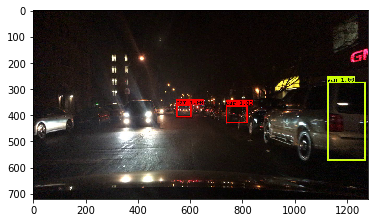

In [47]:
out_scores, out_boxes, out_classes = predict_any(sess, model_body,
                                                 val_set_files[ np.random.randint(0,high=len(val_set_files)) ],
                                                 anchors, class_names,
                                                max_boxes=17,
                                                  score_threshold=.5,
                                                      iou_threshold = 0.5)

In [41]:
# can compare with training_set_files and val_set_files
data_legth = 400 # How many ramdom samples to evaluate
print(' Training set')
random.shuffle(training_set_files) 
mAP_eval(sess, model_body,training_set_files[0:data_legth],boxes_dir,anchors, class_idx,class_names, max_boxes=17, score_threshold=.5,
                                                      iou_threshold = 0.5,iou_eval_threshold = 0.5, plot_compare = False)
print(' Val set')
random.shuffle(val_set_files) 
mAP_eval(sess, model_body,val_set_files[0:data_legth],boxes_dir,anchors,class_idx, class_names, max_boxes=17, score_threshold=.5,
                                                      iou_threshold = 0.5,iou_eval_threshold = 0.5, plot_compare = False)

 Training set
 mean precision =  0.9098116947472745  , mean recall =   0.8801534036433365
 Final F1 score =   0.8947368421052632
 Val set
 mean precision =  0.9112426035502958  , mean recall =   0.8716981132075472
 Final F1 score =   0.8910318225650917


## 4 Evaluate Test set and generate results


### 4.1 EvaluateTest set


Reshaping input image (720, 1280) to model input shape [416, 416]
Found 1 boxes for /dtorres1/Desktop/Nexar_challenge_2/src/../data/Test/nexet_2017_test/38479.jpg
car 1.00 (475, 243) (836, 541)


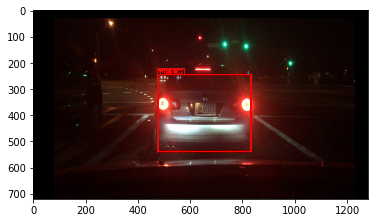

In [77]:
## Evaluate the model on the Test set
out_scores, out_boxes, out_classes = predict_any(sess, model_body,
                                                 test_files[ np.random.randint(0,high=len(test_files)) ],
                                                 anchors, class_names,
                                                max_boxes=17,
                                                  score_threshold=.5,
                                                      iou_threshold = 0.5)

### 4.2 EvaluateTest set and save results to Excel file
Iterativelly evalaute all the Test set and save the rsults on to Excel file

In [43]:
## Evaluate the model on the Test set
df = nexar_eval_test(sess , model_body, test_files , boxes_dir, anchors,class_idx, class_names, 17, score_threshold=0.5,
          iou_threshold=0.5, plot_result=False )

In [44]:
## Save results to an Excel file
df.head()
engine = 'openpyxl' # or 'xlsxwriter', 'xlwt'
df.to_excel(test_results_output.format(engine), engine=engine, index=False)


In [45]:
## Save results to an CSV file
df.head()
df.to_csv(test_results_output_csv, index=False)


In [46]:
df.head()


,image_filename,x0,y0,x1,y1,label,confidence
0,33608.jpg,135.387604,357.204742,401.129883,636.520569,bus,0.997904
1,53141.jpg,489.235168,360.573700,531.262756,403.500366,bus,0.958968
2,53141.jpg,614.453064,379.704407,642.138306,407.264740,car,0.595064
3,33483.jpg,423.556976,334.861938,540.703186,425.355042,car,1.000000
4,33483.jpg,829.728455,353.007202,934.477173,453.111786,car,0.999966
